#Performing Maximum Likelihood Estimates (MLEs) in IPython

By Delaney Granizo-Mackenzie and Andrei Kirilenko.

This notebook developed in collaboration with Prof. Andrei Kirilenko as part of the Masters of Finance curriculum at MIT Sloan.

Part of the Quantopian Lecture Series:

* [www.quantopian.com/lectures](https://www.quantopian.com/lectures)
* [github.com/quantopian/research_public](https://github.com/quantopian/research_public)

Notebook released under the Creative Commons Attribution 4.0 License.

---

In this tutorial notebook we'll do the following things:
1. Compute the MLE for a normal distribution.
2. Compute the MLE for an exponential distribution.
3. Fit a normal distribution to asset returns using MLE.

First we need to import some libraries

In [13]:
import math
import matplotlib.pyplot as plt
import numpy as np
import scipy
import scipy.stats

##Normal Distribution
We'll start by sampling some data from a normal distribution.

In [14]:
TRUE_MEAN = 40
TRUE_STD = 10
X = np.random.normal(TRUE_MEAN, TRUE_STD, 1000)

Now we'll define functions that given our data, will compute the MLE for the $\mu$ and $\sigma$ parameters of the normal distribution.

Recall that

$$\hat\mu = \frac{1}{T}\sum_{t=1}^{T} x_t$$

$$\hat\sigma = \sqrt{\frac{1}{T}\sum_{t=1}^{T}{(x_t - \hat\mu)^2}}$$

In [15]:
def normal_mu_MLE(X):
    # Get the number of observations
    T = len(X)
    # Sum the observations
    s = sum(X)
    return 1.0/T * s

def normal_sigma_MLE(X):
    T = len(X)
    # Get the mu MLE
    mu = normal_mu_MLE(X)
    # Sum the square of the differences
    s = sum( np.power((X - mu), 2) )
    # Compute sigma^2
    sigma_squared = 1.0/T * s
    return math.sqrt(sigma_squared)

Now let's try our functions out on our sample data and see how they compare to the built-in `np.mean` and `np.std`

In [16]:
print "Mean Estimation"
print normal_mu_MLE(X)
print np.mean(X)
print "Standard Deviation Estimation"
print normal_sigma_MLE(X)
print np.std(X)

Mean Estimation
39.5829392522
39.5829392522
Standard Deviation Estimation
10.2920350139
10.2920350139


Now let's estimate both parameters at once with scipy's built in `fit()` function.

In [17]:
mu, std = scipy.stats.norm.fit(X)
print "mu estimate: " + str(mu)
print "std estimate: " + str(std)

mu estimate: 39.5829392522
std estimate: 10.2920350139


Now let's plot the distribution PDF along with the data to see how well it fits. We can do that by accessing the pdf provided in `scipy.stats.norm.pdf`.

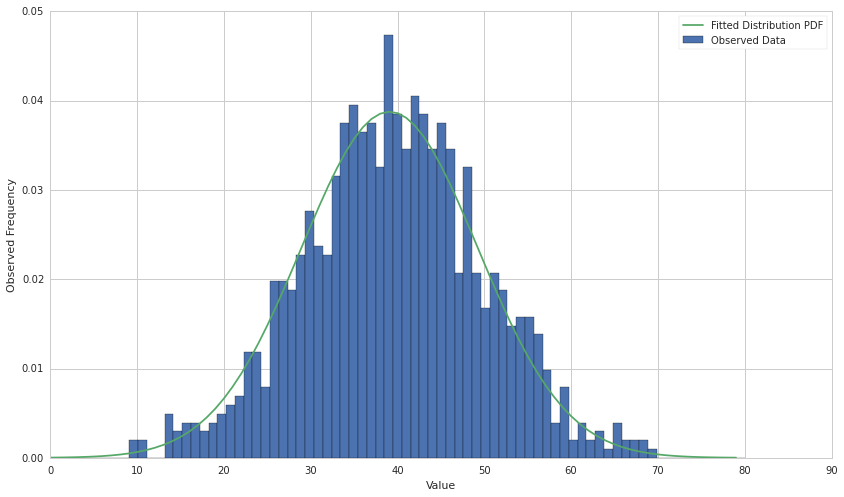

In [18]:
pdf = scipy.stats.norm.pdf
# We would like to plot our data along an x-axis ranging from 0-80 with 80 intervals
# (increments of 1)
x = np.linspace(0, 80, 80)
plt.hist(X, bins=x, normed='true')
plt.plot(pdf(x, loc=mu, scale=std))
plt.xlabel('Value')
plt.ylabel('Observed Frequency')
plt.legend(['Fitted Distribution PDF', 'Observed Data', ]);

##Exponential Distribution
Let's do the same thing, but for the exponential distribution. We'll start by sampling some data.

In [37]:
TRUE_LAMBDA = 5
X = np.random.exponential(TRUE_LAMBDA, 1000)

`numpy` defines the exponential distribution as
$$\frac{1}{\lambda}e^{-\frac{x}{\lambda}}$$

So we need to invert the MLE from the lecture notes. There it is

$$\hat\lambda = \frac{T}{\sum_{t=1}^{T} x_t}$$

Here it's just the reciprocal, so

$$\hat\lambda = \frac{\sum_{t=1}^{T} x_t}{T}$$

In [38]:
def exp_lamda_MLE(X):
    T = len(X)
    s = sum(X)
    return s/T

In [39]:
print "lambda estimate: " + str(exp_lamda_MLE(X))

lambda estimate: 4.71513802853


In [40]:
# The scipy version of the exponential distribution has a location parameter
# that can skew the distribution. We ignore this by fixing the location
# parameter to 0 with floc=0
_, l = scipy.stats.expon.fit(X, floc=0)

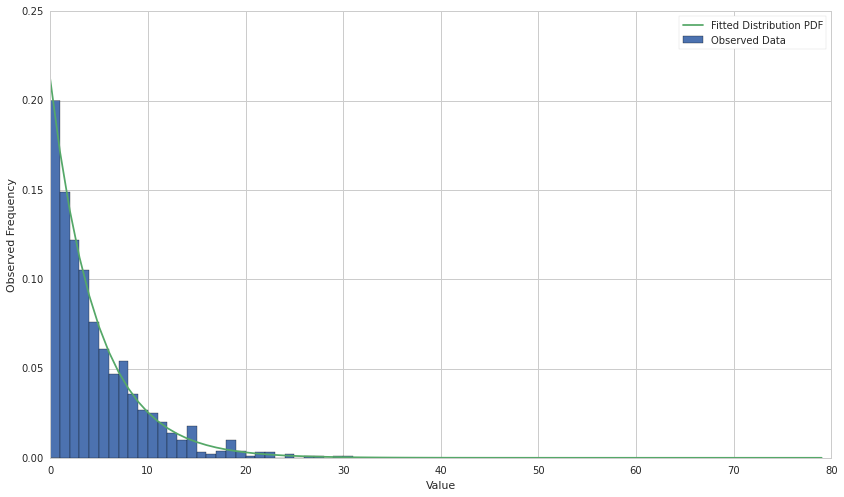

In [41]:
pdf = scipy.stats.expon.pdf
x = range(0, 80)
plt.hist(X, bins=x, normed='true')
plt.plot(pdf(x, scale=l))
plt.xlabel('Value')
plt.ylabel('Observed Frequency')
plt.legend(['Fitted Distribution PDF', 'Observed Data', ]);

##MLE for Asset Returns

Now we'll fetch some real returns and try to fit a normal distribution to them using MLE.

In [42]:
prices = get_pricing('TSLA', fields='price', start_date='2014-01-01', end_date='2015-01-01')
# This will give us the number of dollars returned each day
absolute_returns = np.diff(prices)
# This will give us the percentage return over the last day's value
# the [:-1] notation gives us all but the last item in the array
# We do this because there are no returns on the final price in the array.
returns = absolute_returns/prices[:-1]

Let's use `scipy`'s fit function to get the $\mu$ and $\sigma$ MLEs.

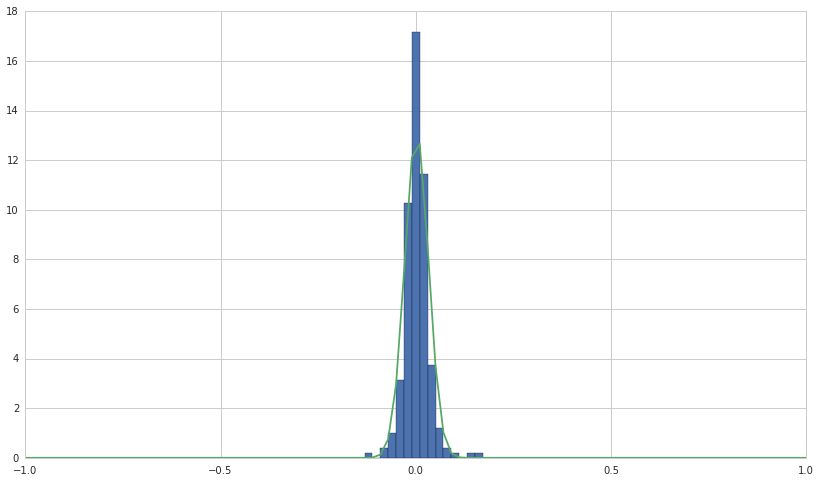

In [43]:
mu, std = scipy.stats.norm.fit(returns)
pdf = scipy.stats.norm.pdf
x = np.linspace(-1,1, num=100)
h = plt.hist(returns, bins=x, normed='true')
l = plt.plot(x, pdf(x, loc=mu, scale=std))

Of course, this fit is meaningless unless we've tested that they obey a normal distribution first. We can test this using the Jarque-Bera normality test. The Jarque-Bera test will reject the hypothesis of a normal distribution if the p-value is under a c

In [45]:
from statsmodels.stats.stattools import jarque_bera
jarque_bera(returns)

(242.53773931956744,
 2.1557534018848578e-53,
 0.7405363946340933,
 7.582279228661398)

In [46]:
jarque_bera(np.random.normal(0, 1, 100))

(0.9856724005093672,
 0.61089132471452023,
 -0.10806345762002881,
 2.5642815902086933)

*This presentation is for informational purposes only and does not constitute an offer to sell, a solicitation to buy, or a recommendation for any security; nor does it constitute an offer to provide investment advisory or other services by Quantopian, Inc. ("Quantopian"). Nothing contained herein constitutes investment advice or offers any opinion with respect to the suitability of any security, and any views expressed herein should not be taken as advice to buy, sell, or hold any security or as an endorsement of any security or company.  In preparing the information contained herein, Quantopian, Inc. has not taken into account the investment needs, objectives, and financial circumstances of any particular investor. Any views expressed and data illustrated herein were prepared based upon information, believed to be reliable, available to Quantopian, Inc. at the time of publication. Quantopian makes no guarantees as to their accuracy or completeness. All information is subject to change and may quickly become unreliable for various reasons, including changes in market conditions or economic circumstances.*